In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO

In [2]:
import ot2_env  # needed to trigger registration

pybullet build time: Nov 28 2023 23:45:17


In [3]:
# Configuration
max_steps = 500
dt = 1.0 / 240.0
num_targets = 8

# Workspace limits
workspace_limits = {
    "x": (-0.1875, 0.2532),
    "y": (-0.17010, 0.2198),
    "z": (0.1195, 0.2903),
}

# Generate random targets within workspace
np.random.seed(42)  # For reproducibility
targets = []
for _ in range(num_targets):
    x = np.random.uniform(workspace_limits["x"][0], workspace_limits["x"][1])
    y = np.random.uniform(workspace_limits["y"][0], workspace_limits["y"][1])
    z = np.random.uniform(workspace_limits["z"][0], workspace_limits["z"][1])
    targets.append([x, y, z])

print(f"Generated {num_targets} random targets within workspace:")
for i, t in enumerate(targets):
    print(f"  Target {i+1}: [{t[0]:.4f}, {t[1]:.4f}, {t[2]:.4f}]")

Generated 8 random targets within workspace:
  Target 1: [-0.0224, 0.2006, 0.2445]
  Target 2: [0.0763, -0.1093, 0.1461]
  Target 3: [-0.1619, 0.1676, 0.2222]
  Target 4: [0.1245, -0.1621, 0.2852]
  Target 5: [0.1794, -0.0873, 0.1506]
  Target 6: [-0.1067, -0.0515, 0.2091]
  Target 7: [0.0029, -0.0565, 0.2240]
  Target 8: [-0.1260, -0.0562, 0.1821]


In [4]:
# Load RL model
model_path = "artifacts/model.zip"
model = PPO.load(model_path)
print(f"Loaded RL model from {model_path}")

Loaded RL model from artifacts/model.zip


In [5]:
# Storage for all target runs
all_distances = []
all_errors_x = []
all_errors_y = []
all_errors_z = []
final_distances = []
convergence_times = []

In [6]:
for t_idx, target in enumerate(targets):
    print(f"\n{'='*50}")
    print(f"TARGET {t_idx + 1}/{len(targets)}: {target}")
    print('='*50)
    
    # Create fresh environment for each target
    env = gym.make("OT2ENV-v0", target=target, max_steps=max_steps, render_mode="none")
    
    # Data collection for this target
    distances = []
    errors_x = []
    errors_y = []
    errors_z = []
    
    # Reset environment
    obs, info = env.reset(seed=42 + t_idx)  # Different seed per target for variety
    
    # Set pipette to a valid starting position
    start_position = (0.10775, 0.062, 0.1215)
    env.unwrapped.sim.set_start_position(*start_position)
    
    # Set the target BEFORE getting updated obs
    env.unwrapped.target = np.array(target)
    
    # Get updated state after repositioning
    states = env.unwrapped.sim.get_states()
    obs = env.unwrapped._get_obs(states)
    info = env.unwrapped._get_info(states)
    
    # Disable env's single-target termination
    env.unwrapped.dwell_steps = max_steps + 1
    
    # Also disable terminated flag checking if there's a distance threshold
    if hasattr(env.unwrapped, 'terminate_on_target'):
        env.unwrapped.terminate_on_target = False
    
    robot_key = list(info['pipette_positions'].keys())[0]
    print(f"Starting position: {info['pipette_positions'][robot_key]}")
    print(f"Target: {env.unwrapped.target}")
    
    threshold_reached_step = None
    
    for step in range(max_steps):
        pipette_pos = np.array(info['pipette_positions'][robot_key])
        x, y, z = pipette_pos
        target_x, target_y, target_z = target
        
        error_x = target_x - x
        error_y = target_y - y
        error_z = target_z - z
        distance = np.sqrt(error_x**2 + error_y**2 + error_z**2)
        
        distances.append(distance)
        errors_x.append(abs(error_x))
        errors_y.append(abs(error_y))
        errors_z.append(abs(error_z))
        
        # Track first time threshold is reached
        if threshold_reached_step is None and distance < 0.001:
            threshold_reached_step = step
        
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        
        # Print progress every 100 steps
        if step % 100 == 0:
            print(f"Step {step}: Distance={distance:.6f}m, Reward={reward:.4f}")
        
        # DON'T break on terminated - we want full runs for comparison
        if truncated:
            print(f"Episode truncated at step {step}")
            break
    
    env.close()
    
    # Store results for this target
    all_distances.append(distances)
    all_errors_x.append(errors_x)
    all_errors_y.append(errors_y)
    all_errors_z.append(errors_z)
    final_distances.append(distances[-1])
    
    if threshold_reached_step is not None:
        convergence_times.append(threshold_reached_step * dt)
        print(f"Target reached at step {threshold_reached_step} ({threshold_reached_step * dt:.3f}s)")
    else:
        convergence_times.append(None)
        print("Target threshold not reached")
    
    print(f"Final distance: {distances[-1]:.6f}m")

# Compute mean trajectories (pad shorter runs if needed)
max_len = max(len(d) for d in all_distances)
timestamps = [i * dt for i in range(max_len)]

def pad_and_stack(arrays, max_len):
    """Pad arrays to same length and stack for mean calculation."""
    padded = []
    for arr in arrays:
        if len(arr) < max_len:
            arr = arr + [arr[-1]] * (max_len - len(arr))  # Pad with final value
        padded.append(arr)
    return np.array(padded)


TARGET 1/8: [-0.02244016962396736, 0.20058350806922634, 0.244524565261388]
Starting position: [0.1077, 0.062, 0.1215]
Target: [-0.02244017  0.20058351  0.24452457]
Step 0: Distance=0.226444m, Reward=-0.0100
Step 100: Distance=0.001167m, Reward=0.1247
Step 200: Distance=0.000993m, Reward=0.4488
Step 300: Distance=0.000602m, Reward=0.4880
Step 400: Distance=0.001140m, Reward=0.0903
Episode truncated at step 499
Target reached at step 46 (0.192s)
Final distance: 0.000933m

TARGET 2/8: [0.07632879398563402, -0.109268332091494, 0.14614386407342342]
Starting position: [0.1077, 0.062, 0.1215]
Target: [ 0.07632879 -0.10926833  0.14614386]
Step 0: Distance=0.175853m, Reward=-0.0100
Step 100: Distance=0.000295m, Reward=0.4059
Step 200: Distance=0.000360m, Reward=0.4582
Step 300: Distance=0.000951m, Reward=0.4730
Step 400: Distance=0.000502m, Reward=0.4656
Episode truncated at step 499
Target reached at step 53 (0.221s)
Final distance: 0.000061m

TARGET 3/8: [-0.1619025521174745, 0.1676220792376

In [7]:
dist_array = pad_and_stack(all_distances, max_len)
ex_array = pad_and_stack(all_errors_x, max_len)
ey_array = pad_and_stack(all_errors_y, max_len)
ez_array = pad_and_stack(all_errors_z, max_len)

mean_distances = np.mean(dist_array, axis=0)
std_distances = np.std(dist_array, axis=0)
mean_errors_x = np.mean(ex_array, axis=0)
std_errors_x = np.std(ex_array, axis=0)
mean_errors_y = np.mean(ey_array, axis=0)
std_errors_y = np.std(ey_array, axis=0)
mean_errors_z = np.mean(ez_array, axis=0)
std_errors_z = np.std(ez_array, axis=0)

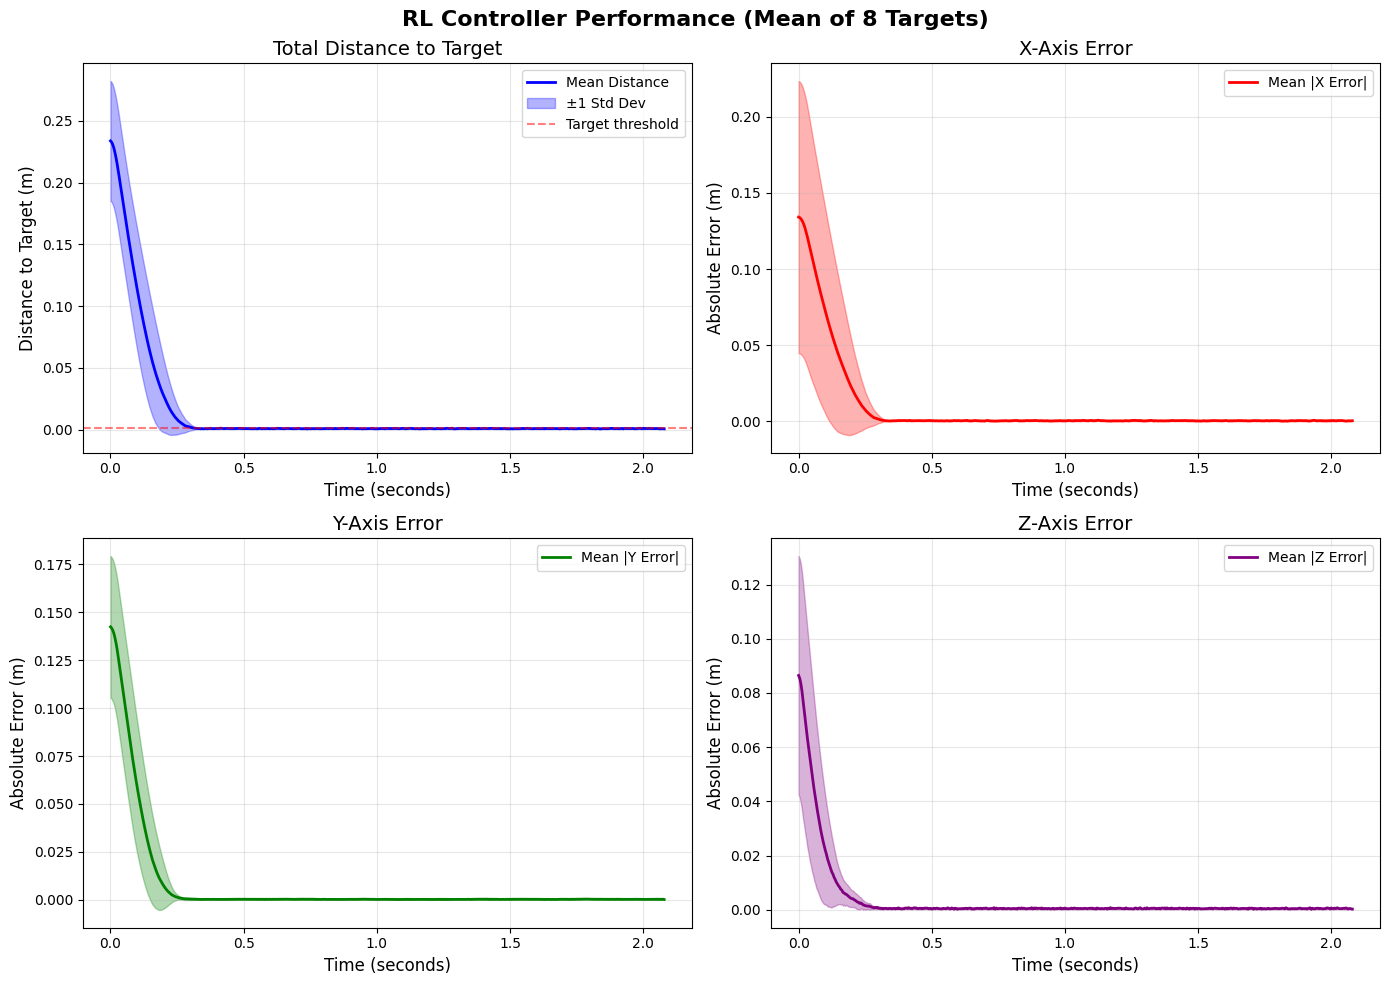

In [8]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'RL Controller Performance (Mean of {len(targets)} Targets)', fontsize=16, fontweight='bold')

# Plot 1: Total distance with std band
ax = axes[0, 0]
ax.plot(timestamps, mean_distances, linewidth=2, color='blue', label='Mean Distance')
ax.fill_between(timestamps, mean_distances - std_distances, mean_distances + std_distances, 
                alpha=0.3, color='blue', label='±1 Std Dev')
ax.set_xlabel('Time (seconds)', fontsize=12)
ax.set_ylabel('Distance to Target (m)', fontsize=12)
ax.set_title('Total Distance to Target', fontsize=14)
ax.grid(True, alpha=0.3)
ax.axhline(y=0.001, color='r', linestyle='--', label='Target threshold', alpha=0.5)
ax.legend()

# Plot 2: X-axis error
ax = axes[0, 1]
ax.plot(timestamps, mean_errors_x, linewidth=2, color='red', label='Mean |X Error|')
ax.fill_between(timestamps, mean_errors_x - std_errors_x, mean_errors_x + std_errors_x,
                alpha=0.3, color='red')
ax.set_xlabel('Time (seconds)', fontsize=12)
ax.set_ylabel('Absolute Error (m)', fontsize=12)
ax.set_title('X-Axis Error', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend()

# Plot 3: Y-axis error
ax = axes[1, 0]
ax.plot(timestamps, mean_errors_y, linewidth=2, color='green', label='Mean |Y Error|')
ax.fill_between(timestamps, mean_errors_y - std_errors_y, mean_errors_y + std_errors_y,
                alpha=0.3, color='green')
ax.set_xlabel('Time (seconds)', fontsize=12)
ax.set_ylabel('Absolute Error (m)', fontsize=12)
ax.set_title('Y-Axis Error', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend()

# Plot 4: Z-axis error
ax = axes[1, 1]
ax.plot(timestamps, mean_errors_z, linewidth=2, color='purple', label='Mean |Z Error|')
ax.fill_between(timestamps, mean_errors_z - std_errors_z, mean_errors_z + std_errors_z,
                alpha=0.3, color='purple')
ax.set_xlabel('Time (seconds)', fontsize=12)
ax.set_ylabel('Absolute Error (m)', fontsize=12)
ax.set_title('Z-Axis Error', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

In [9]:
# Summary statistics
print("\n" + "="*60)
print("RL CONTROLLER PERFORMANCE SUMMARY (MULTI-TARGET)")
print("="*60)
print(f"Number of targets tested: {len(targets)}")
print(f"\nFinal Distance Statistics:")
print(f"  Mean: {np.mean(final_distances):.6f} m")
print(f"  Std:  {np.std(final_distances):.6f} m")
print(f"  Min:  {np.min(final_distances):.6f} m")
print(f"  Max:  {np.max(final_distances):.6f} m")

valid_conv = [t for t in convergence_times if t is not None]
print(f"\nConvergence Time (<0.001m):")
if valid_conv:
    print(f"  Mean: {np.mean(valid_conv):.3f} s")
    print(f"  Std:  {np.std(valid_conv):.3f} s")
    print(f"  Targets converged: {len(valid_conv)}/{len(targets)}")
else:
    print("  No targets reached threshold")

print(f"\nPer-Axis Final Errors (Mean ± Std):")
print(f"  X: {np.mean([e[-1] for e in all_errors_x]):.6f} ± {np.std([e[-1] for e in all_errors_x]):.6f} m")
print(f"  Y: {np.mean([e[-1] for e in all_errors_y]):.6f} ± {np.std([e[-1] for e in all_errors_y]):.6f} m")
print(f"  Z: {np.mean([e[-1] for e in all_errors_z]):.6f} ± {np.std([e[-1] for e in all_errors_z]):.6f} m")
print("="*60)


RL CONTROLLER PERFORMANCE SUMMARY (MULTI-TARGET)
Number of targets tested: 8

Final Distance Statistics:
  Mean: 0.000574 m
  Std:  0.000285 m
  Min:  0.000061 m
  Max:  0.000933 m

Convergence Time (<0.001m):
  Mean: 0.253 s
  Std:  0.053 s
  Targets converged: 8/8

Per-Axis Final Errors (Mean ± Std):
  X: 0.000455 ± 0.000251 m
  Y: 0.000146 ± 0.000131 m
  Z: 0.000250 ± 0.000199 m
